In [62]:
import torch
import numpy as np
import pandas as pd
import requests

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, DeepAR
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [63]:
import dash

In [64]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'

In [65]:
r = requests.get(URL)
data_json = r.json()

In [66]:
df = pd.DataFrame.from_dict(data_json, 'index')

In [67]:
xs = df.drop(columns='data')
raw_ys = df.data

In [68]:
xs.shape

(215, 17)

In [69]:
import matplotlib.pyplot as plt


In [70]:
nans = xs.isnull().sum()

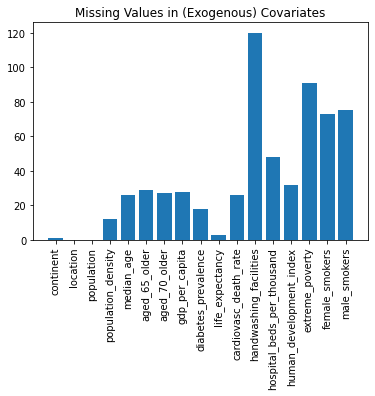

In [71]:
# look at missing values
plt.bar(nans.index.values, nans.values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

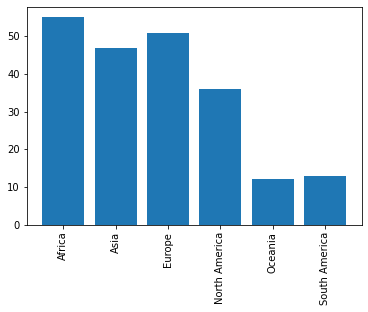

In [72]:
plt.bar(xs.groupby('continent').size().index, xs.groupby('continent').size())
plt.xticks(rotation = 90);

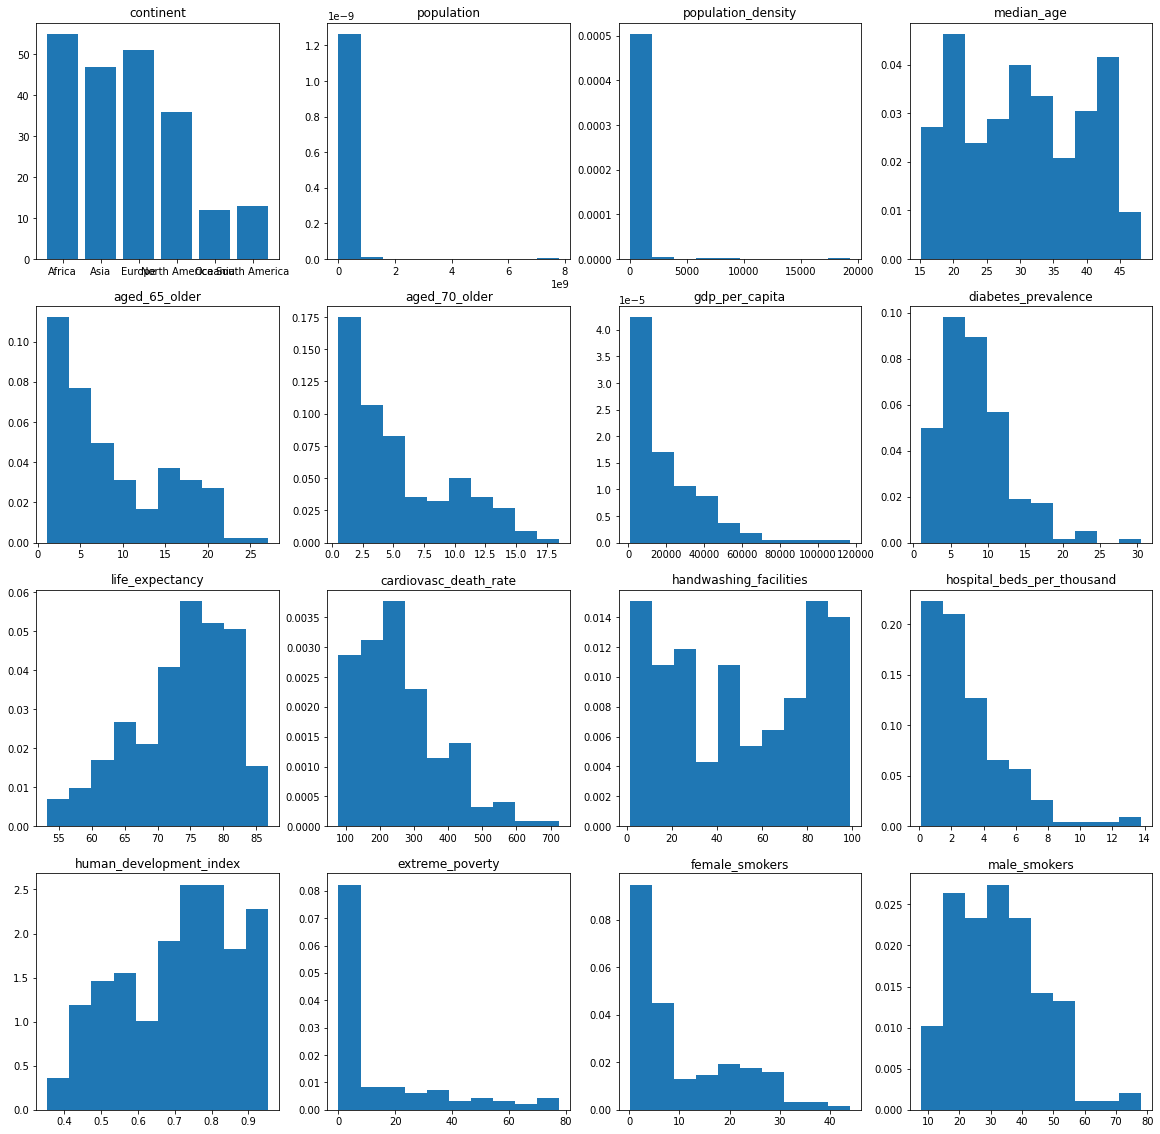

In [73]:
# plot histograms for all xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(20,20))
# ax.set_title("Distribution of Covariates")

i = 0
for x in xs.columns:
    if(x == 'location'):
        continue
        
    i += 1
    ax = fig.add_subplot(4,4,i)
        
    if is_numeric_dtype(xs[x]):
        
        ax.set_title(x)
        ax.hist(xs[x],density=True)
    
    else:
        
        ax.bar(xs.groupby(x).size().index, xs.groupby(x).size())
        ax.set_title(x)
        
        
fig;

In [74]:
# init df with first country
ys = pd.DataFrame(raw_ys[0])
ys['location'] = raw_ys.index[0]
ys = ys.set_index('location')
ys = ys.reset_index()

# append new ones
for i in range(1,len(raw_ys)):
    new_ys = pd.DataFrame(raw_ys[i])
    new_ys['location'] = raw_ys.index[i]
    ys = ys.append(new_ys)




In [75]:
ys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59637 entries, 0 to 334
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location                            59637 non-null  object 
 1   date                                59637 non-null  object 
 2   total_cases                         56023 non-null  float64
 3   new_cases                           58957 non-null  float64
 4   new_deaths                          58957 non-null  float64
 5   total_cases_per_million             56023 non-null  float64
 6   new_cases_per_million               58957 non-null  float64
 7   new_deaths_per_million              58957 non-null  float64
 8   stringency_index                    48463 non-null  float64
 9   new_cases_smoothed                  58157 non-null  float64
 10  new_deaths_smoothed                 58157 non-null  float64
 11  new_cases_smoothed_per_million      58157 n

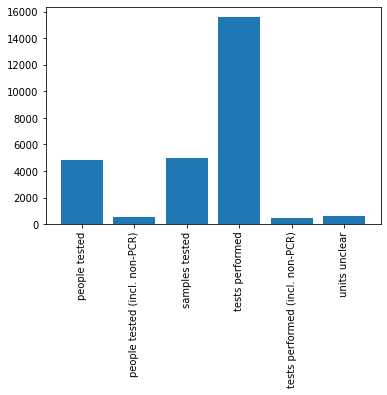

In [76]:
plt.bar(ys.groupby('tests_units').size().index, ys.groupby('tests_units').size())
plt.xticks(rotation = 90);

In [77]:
(df == 0).sum()

continent                     0
location                      0
population                    0
population_density            0
median_age                    0
aged_65_older                 0
aged_70_older                 0
gdp_per_capita                0
diabetes_prevalence           0
life_expectancy               0
data                          0
cardiovasc_death_rate         0
handwashing_facilities        0
hospital_beds_per_thousand    0
human_development_index       0
extreme_poverty               0
female_smokers                0
male_smokers                  0
dtype: int64

In [78]:
xs.columns, ys.columns

(Index(['continent', 'location', 'population', 'population_density',
        'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita',
        'diabetes_prevalence', 'life_expectancy', 'cardiovasc_death_rate',
        'handwashing_facilities', 'hospital_beds_per_thousand',
        'human_development_index', 'extreme_poverty', 'female_smokers',
        'male_smokers'],
       dtype='object'),
 Index(['location', 'date', 'total_cases', 'new_cases', 'new_deaths',
        'total_cases_per_million', 'new_cases_per_million',
        'new_deaths_per_million', 'stringency_index', 'new_cases_smoothed',
        'new_deaths_smoothed', 'new_cases_smoothed_per_million',
        'new_deaths_smoothed_per_million', 'total_deaths',
        'total_deaths_per_million', 'reproduction_rate', 'total_tests',
        'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
        'tests_units', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
        'tests_per_case', 'positive_rate

In [79]:
data = ys.join(xs, on='location',rsuffix="_x").drop(columns='location_x')

In [80]:
# should have the same number of rows
data.shape, ys.shape

((59637, 49), (59637, 33))

In [81]:
# prepare data for consumption
# generously copied from https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html for testing
# compute time index in days from t0
data['date'] = pd.to_datetime(data['date'])
t_zero = data['date'].min()
data['time_idx'] = (data['date'] - t_zero).dt.days

# fill world-level continent label
data["continent"] = data["continent"].fillna('Global')

# fill nans in test units
data["tests_units"] = data["tests_units"].fillna('NA')

# TODO: see if wwe might need additional feature
data["month"] = data.date.dt.month.astype(str).astype("category")
data["continent"] = data["continent"].astype("category")
data["tests_units"] = data["tests_units"].astype("category")


In [82]:
data.sample(10)

,location,date,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,new_deaths_per_million,stringency_index,new_cases_smoothed,...,life_expectancy,cardiovasc_death_rate,handwashing_facilities,hospital_beds_per_thousand,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
24,MKD,2020-01-24,NaN,0.0,0.0,NaN,0.000,0.000,NaN,0.000,...,75.80,322.688,NaN,4.28,0.757,5.0,NaN,NaN,24,1
91,COL,2020-06-06,36635.0,1515.0,58.0,719.987,29.774,1.140,87.04,1421.000,...,77.29,124.240,65.386,1.71,0.747,4.5,4.7,13.5,158,6
127,TUR,2020-07-19,218717.0,918.0,17.0,2593.306,10.885,0.202,63.89,962.286,...,77.69,171.285,NaN,2.81,0.791,0.2,14.1,41.1,201,7
96,URY,2020-06-19,850.0,1.0,0.0,244.694,0.288,0.000,57.41,0.429,...,77.91,160.708,NaN,2.80,0.804,0.1,14.0,19.9,171,6
23,DNK,2020-01-23,NaN,0.0,0.0,NaN,0.000,0.000,0.00,0.000,...,80.90,114.767,NaN,2.50,0.929,0.2,19.3,18.8,23,1
136,PRT,2020-07-11,45679.0,402.0,2.0,4479.780,39.424,0.196,71.30,360.429,...,82.05,127.842,NaN,3.39,0.847,0.5,16.3,30.0,193,7
87,NPL,2020-03-27,3.0,0.0,0.0,0.103,0.000,0.000,96.30,0.286,...,70.78,260.797,47.782,0.30,0.574,15.0,9.5,37.8,87,3
81,JOR,2020-05-27,718.0,7.0,0.0,70.370,0.686,0.000,77.78,9.857,...,74.53,208.257,NaN,1.40,0.735,0.1,NaN,NaN,148,5
137,ZAF,2020-06-23,101590.0,4288.0,61.0,1712.902,72.300,1.029,76.85,4008.143,...,64.13,200.380,43.993,2.32,0.699,18.9,8.1,33.2,175,6
232,IRQ,2020-08-19,184709.0,4576.0,82.0,4592.181,113.767,2.039,92.59,3959.143,...,70.60,218.612,94.576,1.40,0.685,2.5,NaN,NaN,232,8


In [83]:
# assign new unique index 
data.index = range(0,data.shape[0])

In [84]:
data.dtypes

location                                      object
date                                  datetime64[ns]
total_cases                                  float64
new_cases                                    float64
new_deaths                                   float64
total_cases_per_million                      float64
new_cases_per_million                        float64
new_deaths_per_million                       float64
stringency_index                             float64
new_cases_smoothed                           float64
new_deaths_smoothed                          float64
new_cases_smoothed_per_million               float64
new_deaths_smoothed_per_million              float64
total_deaths                                 float64
total_deaths_per_million                     float64
reproduction_rate                            float64
total_tests                                  float64
new_tests                                    float64
total_tests_per_thousand                     f

In [85]:
ｍax_pred_length = 14 # predict at most two weeks
max_encoder_length = 60 # use at most 2 months as input
training_cutoff = data['time_idx'].max() - max_pred_length

targets = 'new_cases'
#['new_cases', 'new_deaths', 'icu_patients', 'hosp_patients', 'total_cases', 'total_deaths','reproduction_rate']

from pytorch_forecasting.data.encoders import NaNLabelEncoder

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target=targets,
    group_ids=['location'],
    min_encoder_length=int(max_encoder_length / 2),
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'],
    static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers'],
    time_varying_known_categoricals=['month'],
    time_varying_unknown_reals=['time_idx','stringency_index', 'new_tests', 'positive_rate'],
    target_normalizer=GroupNormalizer(groups=['location'],coerce_positive=False),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 3 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'MHL'}, {'__group_id__location': 'VUT'}, {'__group_id__location': 'WLF'}]
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'MHL'}, {'__group_id__location': 'VUT'}]
  warnings.warn(


In [86]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

nan

In [87]:
actuals.shape

torch.Size([213, 14])

In [88]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 35.2k


In [89]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.6 K 
3  | prescalers                         | ModuleDict                      | 368   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn